In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### Cargar base de datos

In [2]:
dataset = pd.read_csv("datasets/data_globant_cnn.csv")
dataset.head()

,Date,Position,Seniority,Location,Studio,Client Tag,Project Tag,Team Name,Month,Day,EmployeeID,Engagement_D
0,02Jan23,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,1,2,66,Alto
1,03Jan23,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,1,3,66,Medio
2,04Jan23,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,1,4,66,Medio
3,05Jan23,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,1,5,66,Medio
4,06Jan23,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,1,6,66,Alto


In [3]:
# Convertimos la columna "Date" de texto a formato de fecha (datetime)
dataset["Date"] = pd.to_datetime(dataset["Date"], format="%d%b%y")

# Ordenamos el dataset primero por "EmployeeID" y luego por "Date"
dataset = dataset.sort_values(["EmployeeID", "Date"])
dataset.head()

,Date,Position,Seniority,Location,Studio,Client Tag,Project Tag,Team Name,Month,Day,EmployeeID,Engagement_D
6005,2023-01-02,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,2,0,Alto
6006,2023-01-03,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,3,0,Alto
6007,2023-01-04,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,4,0,Alto
6008,2023-01-05,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,5,0,Muy Alto
6009,2023-01-06,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,6,0,Alto


### Separar columnas

In [4]:
# Lista de columnas categóricas
categorical_cols = [
    "Position",
    "Location",
    "Studio",
    "Client Tag",
    "Project Tag",
    "Team Name"
]

# Lista de columnas numéricas
numeric_cols = ["Seniority", "Month", "Day"]

# Nombre de la columna objetivo
target_col = "Engagement_D"

# Nombre de la columna que identifica a cada empleado
employee_col = "EmployeeID"

### Transformación de datos

In [5]:
# Diccionario para guardar los LabelEncoders usados en cada columna categórica
encoders = {}

# Recorremos cada columna categórica para codificarla
for col in categorical_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col].astype(str))
    encoders[col] = le

# Codificamos la variable objetivo
encoder_target = LabelEncoder()
dataset[target_col] = encoder_target.fit_transform(dataset[target_col].astype(str))

# Creamos el escalador para las columnas numéricas
scaler = MinMaxScaler()
dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])

# Lista final de columnas que usaremos como features del modelo
feature_cols = numeric_cols + categorical_cols


### Crear ventanas de tiempo

In [6]:
# Función para crear ventanas (secuencias de días) para un empleado
def create_windows_employee(df_emp, window=14):
    X, y = [], []

    data = df_emp[feature_cols].values # Extraemos los valores 
    labels = df_emp[target_col].values # Extraemos las etiquetas

    # Recorremos la serie de tiempo del empleado
    for i in range(len(df_emp) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window])

    return np.array(X), np.array(y)

X_all, y_all = [], []

# Recorremos cada empleado único
for emp in dataset[employee_col].unique():
    df_emp = dataset[dataset[employee_col] == emp] # Filtramos solo las filas de ese empleado
    X_emp, y_emp = create_windows_employee(df_emp, window=14) # Creamos las ventanas para ese empleado
    X_all.append(X_emp)
    y_all.append(y_emp)

# Unimos todas las ventanas de todos los empleados
X = np.concatenate(X_all)
y = np.concatenate(y_all)

# One-hot encoding de las etiquetas
y_cat = to_categorical(y, num_classes=5)

# Imprimimos las dimensiones finales para verificar
print("SHAPES:")
print("X:", X.shape, "y:", y_cat.shape)


SHAPES:
X: (10050, 14, 9) y: (10050, 5)


In [7]:
# Dividimos el dataset completo en entrenamiento y un conjunto temporal
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.20, shuffle=True)

# Ahora dividimos ese 20% en dos partes iguales
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50)

In [8]:
# Obtenemos las etiquetas únicas dentro de y_train y cuántas veces aparece cada una
unique_labels, counts = np.unique(y_train, axis=0, return_counts=True)

# Guardamos el conteo de cada clase según el orden en que aparecen
mb = counts[0]
b = counts[1]
m = counts[2]
a = counts[3]
ma = counts[4]

# Imprimimos el número de muestras en cada clase
print("Muy bajo: ", mb)
print("Bajo: ", b)
print("Medio: ", m)
print("Alto: ", a)
print("Muy alto: ", ma)

Muy bajo:  530
Bajo:  895
Medio:  3181
Alto:  389
Muy alto:  3045


In [9]:
# Arquitectura de la red
dropout_rate = 0.2

inputs = Input(shape=(14, len(feature_cols)))

conv1 = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
mp1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(mp1)
mp2 = MaxPooling1D(pool_size=2)(conv2)

flat = Flatten()(mp2)

hidden1 = Dense(units=256, activation='relu')(flat)
dropHidden1 = Dropout(rate=dropout_rate)(hidden1)

hidden2 = Dense(units=128, activation='relu')(dropHidden1)
dropHidden2 = Dropout(rate=dropout_rate)(hidden2)

hidden3 = Dense(units=64, activation='relu')(dropHidden2)
dropHidden3 = Dropout(rate=dropout_rate)(hidden3)

hidden4 = Dense(units=32, activation='relu')(dropHidden3)
dropHidden4 = Dropout(rate=dropout_rate)(hidden4)

output = Dense(units=5, activation='softmax')(dropHidden4)

model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 32)         │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,421 (220.39 KB)

 Trainable params: 56,421 (220.39 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Sumamos la cantidad total de muestras entre las cinco clases
total = mb + b + m + a + ma

# Para cada clase, calculamos su peso
weight_for_0 = (1 / mb) * (total / 2.0)
weight_for_1 = (1 / b) * (total / 2.0)
weight_for_2 = (1 / m) * (total / 2.0)
weight_for_3 = (1 / a) * (total / 2.0)
weight_for_4 = (1 / ma) * (total / 2.0)

# Diccionario de pesos por clase
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

# Imprimimos los pesos asignados.
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))

Weight for class 0: 7.58
Weight for class 1: 4.49
Weight for class 2: 1.26
Weight for class 3: 10.33
Weight for class 4: 1.32


In [11]:
#early = EarlyStopping(monitor="val_loss", patience=10)

# Creamos el optimizador SGD
optimizer =  tf.keras.optimizers.SGD(learning_rate = 0.004)

# Compilamos el modelo
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenamos el modelo usando model.fit()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=64,
    #callbacks=[early],
    class_weight=class_weight
)

Epoch 1/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3495 - loss: 5.9803 - val_accuracy: 0.4109 - val_loss: 1.5656
Epoch 2/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3767 - loss: 5.4080 - val_accuracy: 0.4209 - val_loss: 1.5183
Epoch 3/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3847 - loss: 5.2340 - val_accuracy: 0.4209 - val_loss: 1.4810
Epoch 4/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3877 - loss: 5.1126 - val_accuracy: 0.4209 - val_loss: 1.5823
Epoch 5/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3902 - loss: 5.0376 - val_accuracy: 0.4229 - val_loss: 1.5248
Epoch 6/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3944 - loss: 4.9695 - val_accuracy: 0.4169 - val_loss: 1.4645
Epoch 7/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3999 - loss: 4.8928 - val_accuracy: 0.4279 - val_loss: 1.4704
Epoch 8/400
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4001 - loss: 4.8371 - val_accu

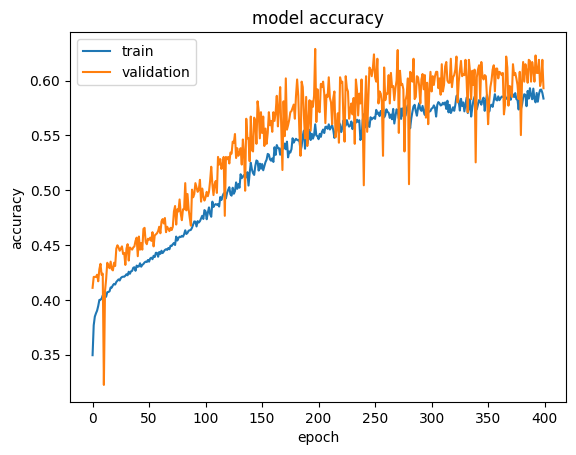

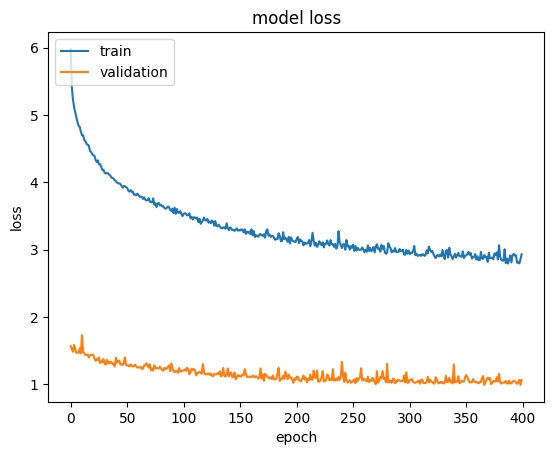

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# Evaluamos el modelo usando el conjunto de prueba (X_test, y_test)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy en test:", test_acc)

Accuracy en test: 0.5820895433425903
